In [1]:
import numpy as np
import json
from pathlib import Path
import os
import random
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from torchsummary import summary

In [2]:
torch.cuda.empty_cache()
learning_rate = 1e-1
lambda_c = 0.1
num_epochs = 100
op_name = "AdamW"
# op_name = "SGD"

In [3]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 42
seed_everything(seed)

In [4]:
def to_label(action):
    strs = action.split(' ')
    unit_id = strs[1]
    if strs[0] == 'm':
        label = {'c': None, 'n': 0, 's': 1, 'w': 2, 'e': 3}[strs[2]]
    elif strs[0] == 'bcity':
        label = 4
    else:
        label = None
    return unit_id, label

def depleted_resources(obs):
    for u in obs['updates']:
        if u.split(' ')[0] == 'r':
            return False
    return True

def create_dataset_from_json(episode_dir, team_name='Toad Brigade'): 
    obses = {}
    samples = []
    append = samples.append
    
    episodes = [path for path in Path(episode_dir).glob('*.json') if 'output' not in path.name]
    for filepath in tqdm(episodes): 
        with open(filepath) as f:
            json_load = json.load(f)

        ep_id = json_load['info']['EpisodeId']
        index = np.argmax([r or 0 for r in json_load['rewards']])
        if json_load['info']['TeamNames'][index] != team_name:
            print(index,filepath)
            continue

        for i in range(len(json_load['steps'])-1):
            if json_load['steps'][i][index]['status'] == 'ACTIVE':
                actions = json_load['steps'][i+1][index]['action']
                obs = json_load['steps'][i][0]['observation']
                
                if depleted_resources(obs):
                    break
                
                obs['player'] = index
                obs = dict([
                    (k,v) for k,v in obs.items() 
                    if k in ['step', 'updates', 'player', 'width', 'height']
                ])
                obs_id = f'{ep_id}_{i}'
                obses[obs_id] = obs
                                
                for action in actions:
                    unit_id, label = to_label(action)
                    if label is not None:
                        append((obs_id, unit_id, label))

    return obses, samples

In [5]:
episode_dir = '../input/lux-ai-episodes'
obses, samples = create_dataset_from_json(episode_dir)
print('obses:', len(obses), 'samples:', len(samples))

  0%|          | 0/1126 [00:00<?, ?it/s]

0 ../input/lux-ai-episodes/30032982.json
1 ../input/lux-ai-episodes/29881187.json
1 ../input/lux-ai-episodes/30084250.json
1 ../input/lux-ai-episodes/29941134.json
0 ../input/lux-ai-episodes/29941132.json
0 ../input/lux-ai-episodes/30362914.json
0 ../input/lux-ai-episodes/29429006.json
1 ../input/lux-ai-episodes/29881186.json
1 ../input/lux-ai-episodes/30226842.json
0 ../input/lux-ai-episodes/30310209.json
0 ../input/lux-ai-episodes/29694898.json
0 ../input/lux-ai-episodes/28825750.json
0 ../input/lux-ai-episodes/29697620.json
0 ../input/lux-ai-episodes/26886148.json
0 ../input/lux-ai-episodes/30362915.json
1 ../input/lux-ai-episodes/29695641.json
0 ../input/lux-ai-episodes/29851612.json
1 ../input/lux-ai-episodes/29698613.json
0 ../input/lux-ai-episodes/30114472.json
1 ../input/lux-ai-episodes/29919414.json
0 ../input/lux-ai-episodes/29744239.json
1 ../input/lux-ai-episodes/30457789.json
1 ../input/lux-ai-episodes/30155524.json
0 ../input/lux-ai-episodes/29831871.json
0 ../input/lux-a

In [6]:
labels = [sample[-1] for sample in samples]
actions = ['north', 'south', 'west', 'east', 'bcity']
for value, count in zip(*np.unique(labels, return_counts=True)):
    print(f'{actions[value]:^5}: {count:>3}')

north: 382547
south: 373710
west : 307699
east : 304856
bcity: 91879


In [7]:
# Input for Neural Network
def make_input(obs, unit_id):
    width, height = obs['width'], obs['height']
    x_shift = (32 - width) // 2
    y_shift = (32 - height) // 2
    cities = {}
    
    b = np.zeros((20, 32, 32), dtype=np.float32)
    
    for update in obs['updates']:
        strs = update.split(' ')
        input_identifier = strs[0]
        
        if input_identifier == 'u':
            x = int(strs[4]) + x_shift
            y = int(strs[5]) + y_shift
            wood = int(strs[7])
            coal = int(strs[8])
            uranium = int(strs[9])
            if unit_id == strs[3]:
                # Position and Cargo
                b[:2, x, y] = (
                    1,
                    (wood + coal + uranium) / 100
                )
            else:
                # Units
                team = int(strs[2])
                cooldown = float(strs[6])
                idx = 2 + (team - obs['player']) % 2 * 3
                b[idx:idx + 3, x, y] = (
                    1,
                    cooldown / 6,
                    (wood + coal + uranium) / 100
                )
        elif input_identifier == 'ct':
            # CityTiles
            team = int(strs[1])
            city_id = strs[2]
            x = int(strs[3]) + x_shift
            y = int(strs[4]) + y_shift
            idx = 8 + (team - obs['player']) % 2 * 2
            b[idx:idx + 2, x, y] = (
                1,
                cities[city_id]
            )
        elif input_identifier == 'r':
            # Resources
            r_type = strs[1]
            x = int(strs[2]) + x_shift
            y = int(strs[3]) + y_shift
            amt = int(float(strs[4]))
            b[{'wood': 12, 'coal': 13, 'uranium': 14}[r_type], x, y] = amt / 800
        elif input_identifier == 'rp':
            # Research Points
            team = int(strs[1])
            rp = int(strs[2])
            b[15 + (team - obs['player']) % 2, :] = min(rp, 200) / 200
        elif input_identifier == 'c':
            # Cities
            city_id = strs[2]
            fuel = float(strs[3])
            lightupkeep = float(strs[4])
            cities[city_id] = min(fuel / lightupkeep, 10) / 10
    
    # Day/Night Cycle
    b[17, :] = obs['step'] % 40 / 40
    # Turns
    b[18, :] = obs['step'] / 360
    # Map Size
    b[19, x_shift:32 - x_shift, y_shift:32 - y_shift] = 1

    return b


class LuxDataset(Dataset):
    def __init__(self, obses, samples):
        self.obses = obses
        self.samples = samples
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        obs_id, unit_id, action = self.samples[idx]
        obs = self.obses[obs_id]
        state = make_input(obs, unit_id)
        
        return state, action

In [8]:
# Neural Network for Lux AI
class BasicConv2d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, bn):
        super().__init__()
        self.conv = nn.Conv2d(
            input_dim, output_dim, 
            kernel_size=kernel_size, 
            padding=(kernel_size[0] // 2, kernel_size[1] // 2)
        )
        self.bn = nn.BatchNorm2d(output_dim) if bn else None

    def forward(self, x):
        h = self.conv(x)
        h = self.bn(h) if self.bn is not None else h
        return h


class LuxNet(nn.Module):
    def __init__(self):
        super().__init__()
        layers, filters = 12, 32
        self.conv0 = BasicConv2d(20, filters, (3, 3), True)
        self.blocks = nn.ModuleList([BasicConv2d(filters, filters, (3, 3), True) for _ in range(layers)])
        self.head_p = nn.Linear(filters, 5, bias=False)

    def forward(self, x):
        h = F.relu_(self.conv0(x))
        for block in self.blocks:
            h = F.relu_(h + block(h))
        h_head = (h * x[:,:1]).view(h.size(0), h.size(1), -1).sum(-1)
        p = self.head_p(h_head)
        return p

In [10]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs):
    best_acc = 0.0
    
    train_losses = []
    val_losses = []
    
    train_accs = []
    val_accs = []
    lrs = []

    lambda1 = lambda epoch: lambda_c ** epoch
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    for epoch in range(num_epochs):
        model.cuda()
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_acc = 0
            
            dataloader = dataloaders_dict[phase]
            for item in tqdm(dataloader, leave=False):
                states = item[0].cuda().float()
                actions = item[1].cuda().long()

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    policy = model(states)
                    loss = criterion(policy, actions)
                    _, preds = torch.max(policy, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += torch.mul(loss.item(), len(policy)).cpu()
                    epoch_acc += torch.sum(preds == actions.data).cpu()

            data_size = len(dataloader.dataset)
            
            epoch_loss = epoch_loss / data_size
            epoch_acc = epoch_acc.double() / data_size
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            print(f'Epoch {epoch + 1}/{num_epochs} |  LR: {scheduler.get_last_lr()} | {phase:^5} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            traced = torch.jit.trace(model.cpu(), torch.rand(1, 20, 32, 32))
            traced.save(f'./pretrained_models_with_large_data/model_{epoch_acc}.pth')
            best_acc = epoch_acc
        else:
            scheduler.step()
        lrs.append(optimizer.param_groups[0]["lr"])
    
    return train_losses, train_accs, val_losses, val_accs, lrs

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = LuxNet().to(device)
summary(model, (20, 32, 32))
train, val = train_test_split(samples, test_size=0.1, random_state=42, stratify=labels)
batch_size = 64
train_loader = DataLoader(
    LuxDataset(obses, train), 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2
)
val_loader = DataLoader(
    LuxDataset(obses, val), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2
)
dataloaders_dict = {"train": train_loader, "val": val_loader}
criterion = nn.CrossEntropyLoss()

optimizers = { 
    'AdamW': optim.AdamW(params=model.parameters(),lr=learning_rate),
    'SGD': optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    }

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           5,792
       BatchNorm2d-2           [-1, 32, 32, 32]              64
       BasicConv2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
       BasicConv2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,248
       BatchNorm2d-8           [-1, 32, 32, 32]              64
       BasicConv2d-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           9,248
      BatchNorm2d-11           [-1, 32, 32, 32]              64
      BasicConv2d-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,248
      BatchNorm2d-14           [-1, 32,

Optimizer: AdamW


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 1/100 |  LR: [0.1] | train | Loss: 1.5457 | Acc: 0.2577


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 1/100 |  LR: [0.1] |  val  | Loss: 1.5466 | Acc: 0.2562


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 2/100 |  LR: [0.1] | train | Loss: 1.5345 | Acc: 0.2584


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 2/100 |  LR: [0.1] |  val  | Loss: 1.5329 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 3/100 |  LR: [0.1] | train | Loss: 1.5333 | Acc: 0.2590


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 3/100 |  LR: [0.1] |  val  | Loss: 1.5397 | Acc: 0.2558


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 4/100 |  LR: [0.010000000000000002] | train | Loss: 1.5293 | Acc: 0.2601


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 4/100 |  LR: [0.010000000000000002] |  val  | Loss: 1.5293 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 5/100 |  LR: [0.0010000000000000002] | train | Loss: 1.5288 | Acc: 0.2613


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 5/100 |  LR: [0.0010000000000000002] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 6/100 |  LR: [0.00010000000000000003] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 6/100 |  LR: [0.00010000000000000003] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 7/100 |  LR: [1.0000000000000003e-05] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 7/100 |  LR: [1.0000000000000003e-05] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 8/100 |  LR: [1.0000000000000004e-06] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 8/100 |  LR: [1.0000000000000004e-06] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 9/100 |  LR: [1.0000000000000005e-07] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 9/100 |  LR: [1.0000000000000005e-07] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 10/100 |  LR: [1.0000000000000004e-08] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 10/100 |  LR: [1.0000000000000004e-08] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 11/100 |  LR: [1.0000000000000005e-09] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 11/100 |  LR: [1.0000000000000005e-09] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 12/100 |  LR: [1.0000000000000006e-10] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 12/100 |  LR: [1.0000000000000006e-10] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 13/100 |  LR: [1.0000000000000006e-11] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 13/100 |  LR: [1.0000000000000006e-11] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 14/100 |  LR: [1.0000000000000006e-12] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 14/100 |  LR: [1.0000000000000006e-12] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 15/100 |  LR: [1.0000000000000007e-13] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 15/100 |  LR: [1.0000000000000007e-13] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 16/100 |  LR: [1.0000000000000008e-14] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 16/100 |  LR: [1.0000000000000008e-14] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 17/100 |  LR: [1.0000000000000009e-15] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 17/100 |  LR: [1.0000000000000009e-15] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 18/100 |  LR: [1.000000000000001e-16] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 18/100 |  LR: [1.000000000000001e-16] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 19/100 |  LR: [1.0000000000000008e-17] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 19/100 |  LR: [1.0000000000000008e-17] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 20/100 |  LR: [1.000000000000001e-18] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 20/100 |  LR: [1.000000000000001e-18] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 21/100 |  LR: [1.000000000000001e-19] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 21/100 |  LR: [1.000000000000001e-19] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 22/100 |  LR: [1.0000000000000011e-20] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 22/100 |  LR: [1.0000000000000011e-20] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 23/100 |  LR: [1.0000000000000012e-21] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 23/100 |  LR: [1.0000000000000012e-21] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 24/100 |  LR: [1.0000000000000012e-22] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 24/100 |  LR: [1.0000000000000012e-22] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 25/100 |  LR: [1.0000000000000013e-23] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 25/100 |  LR: [1.0000000000000013e-23] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 26/100 |  LR: [1.0000000000000014e-24] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 26/100 |  LR: [1.0000000000000014e-24] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 27/100 |  LR: [1.0000000000000014e-25] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 27/100 |  LR: [1.0000000000000014e-25] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 28/100 |  LR: [1.0000000000000015e-26] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 28/100 |  LR: [1.0000000000000015e-26] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 29/100 |  LR: [1.0000000000000015e-27] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 29/100 |  LR: [1.0000000000000015e-27] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 30/100 |  LR: [1.0000000000000015e-28] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 30/100 |  LR: [1.0000000000000015e-28] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 31/100 |  LR: [1.0000000000000016e-29] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 31/100 |  LR: [1.0000000000000016e-29] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 32/100 |  LR: [1.0000000000000017e-30] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 32/100 |  LR: [1.0000000000000017e-30] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 33/100 |  LR: [1.0000000000000016e-31] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 33/100 |  LR: [1.0000000000000016e-31] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 34/100 |  LR: [1.0000000000000017e-32] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 34/100 |  LR: [1.0000000000000017e-32] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 35/100 |  LR: [1.000000000000002e-33] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 35/100 |  LR: [1.000000000000002e-33] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 36/100 |  LR: [1.0000000000000019e-34] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 36/100 |  LR: [1.0000000000000019e-34] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 37/100 |  LR: [1.0000000000000019e-35] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 37/100 |  LR: [1.0000000000000019e-35] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 38/100 |  LR: [1.000000000000002e-36] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 38/100 |  LR: [1.000000000000002e-36] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 39/100 |  LR: [1.000000000000002e-37] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 39/100 |  LR: [1.000000000000002e-37] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 40/100 |  LR: [1.0000000000000022e-38] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 40/100 |  LR: [1.0000000000000022e-38] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 41/100 |  LR: [1.000000000000002e-39] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 41/100 |  LR: [1.000000000000002e-39] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 42/100 |  LR: [1.0000000000000022e-40] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 42/100 |  LR: [1.0000000000000022e-40] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 43/100 |  LR: [1.0000000000000022e-41] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 43/100 |  LR: [1.0000000000000022e-41] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 44/100 |  LR: [1.0000000000000024e-42] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 44/100 |  LR: [1.0000000000000024e-42] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 45/100 |  LR: [1.0000000000000023e-43] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 45/100 |  LR: [1.0000000000000023e-43] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 46/100 |  LR: [1.0000000000000026e-44] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 46/100 |  LR: [1.0000000000000026e-44] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 47/100 |  LR: [1.0000000000000025e-45] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 47/100 |  LR: [1.0000000000000025e-45] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 48/100 |  LR: [1.0000000000000026e-46] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 48/100 |  LR: [1.0000000000000026e-46] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 49/100 |  LR: [1.0000000000000026e-47] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 49/100 |  LR: [1.0000000000000026e-47] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 50/100 |  LR: [1.0000000000000027e-48] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 50/100 |  LR: [1.0000000000000027e-48] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 51/100 |  LR: [1.0000000000000028e-49] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 51/100 |  LR: [1.0000000000000028e-49] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 52/100 |  LR: [1.0000000000000029e-50] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 52/100 |  LR: [1.0000000000000029e-50] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 53/100 |  LR: [1.0000000000000028e-51] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 53/100 |  LR: [1.0000000000000028e-51] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 54/100 |  LR: [1.0000000000000028e-52] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 54/100 |  LR: [1.0000000000000028e-52] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 55/100 |  LR: [1.000000000000003e-53] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 55/100 |  LR: [1.000000000000003e-53] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 56/100 |  LR: [1.000000000000003e-54] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 56/100 |  LR: [1.000000000000003e-54] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 57/100 |  LR: [1.000000000000003e-55] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 57/100 |  LR: [1.000000000000003e-55] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 58/100 |  LR: [1.0000000000000031e-56] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 58/100 |  LR: [1.0000000000000031e-56] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 59/100 |  LR: [1.0000000000000032e-57] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 59/100 |  LR: [1.0000000000000032e-57] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 60/100 |  LR: [1.0000000000000032e-58] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 60/100 |  LR: [1.0000000000000032e-58] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 61/100 |  LR: [1.0000000000000033e-59] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 61/100 |  LR: [1.0000000000000033e-59] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 62/100 |  LR: [1.0000000000000034e-60] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 62/100 |  LR: [1.0000000000000034e-60] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 63/100 |  LR: [1.0000000000000033e-61] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 63/100 |  LR: [1.0000000000000033e-61] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 64/100 |  LR: [1.0000000000000033e-62] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 64/100 |  LR: [1.0000000000000033e-62] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 65/100 |  LR: [1.0000000000000036e-63] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 65/100 |  LR: [1.0000000000000036e-63] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 66/100 |  LR: [1.0000000000000035e-64] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 66/100 |  LR: [1.0000000000000035e-64] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 67/100 |  LR: [1.0000000000000035e-65] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 67/100 |  LR: [1.0000000000000035e-65] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 68/100 |  LR: [1.0000000000000035e-66] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 68/100 |  LR: [1.0000000000000035e-66] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 69/100 |  LR: [1.0000000000000037e-67] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 69/100 |  LR: [1.0000000000000037e-67] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 70/100 |  LR: [1.0000000000000038e-68] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 70/100 |  LR: [1.0000000000000038e-68] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 71/100 |  LR: [1.0000000000000038e-69] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 71/100 |  LR: [1.0000000000000038e-69] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 72/100 |  LR: [1.0000000000000039e-70] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 72/100 |  LR: [1.0000000000000039e-70] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 73/100 |  LR: [1.000000000000004e-71] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 73/100 |  LR: [1.000000000000004e-71] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 74/100 |  LR: [1.000000000000004e-72] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 74/100 |  LR: [1.000000000000004e-72] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 75/100 |  LR: [1.0000000000000041e-73] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 75/100 |  LR: [1.0000000000000041e-73] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 76/100 |  LR: [1.000000000000004e-74] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 76/100 |  LR: [1.000000000000004e-74] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 77/100 |  LR: [1.0000000000000041e-75] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 77/100 |  LR: [1.0000000000000041e-75] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 78/100 |  LR: [1.0000000000000042e-76] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 78/100 |  LR: [1.0000000000000042e-76] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 79/100 |  LR: [1.0000000000000043e-77] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 79/100 |  LR: [1.0000000000000043e-77] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 80/100 |  LR: [1.0000000000000044e-78] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 80/100 |  LR: [1.0000000000000044e-78] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 81/100 |  LR: [1.0000000000000043e-79] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 81/100 |  LR: [1.0000000000000043e-79] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 82/100 |  LR: [1.0000000000000045e-80] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 82/100 |  LR: [1.0000000000000045e-80] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 83/100 |  LR: [1.0000000000000045e-81] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 83/100 |  LR: [1.0000000000000045e-81] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 84/100 |  LR: [1.0000000000000046e-82] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 84/100 |  LR: [1.0000000000000046e-82] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 85/100 |  LR: [1.0000000000000046e-83] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 85/100 |  LR: [1.0000000000000046e-83] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 86/100 |  LR: [1.0000000000000046e-84] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 86/100 |  LR: [1.0000000000000046e-84] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 87/100 |  LR: [1.0000000000000047e-85] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 87/100 |  LR: [1.0000000000000047e-85] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 88/100 |  LR: [1.0000000000000047e-86] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 88/100 |  LR: [1.0000000000000047e-86] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 89/100 |  LR: [1.0000000000000048e-87] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 89/100 |  LR: [1.0000000000000048e-87] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 90/100 |  LR: [1.0000000000000048e-88] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 90/100 |  LR: [1.0000000000000048e-88] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 91/100 |  LR: [1.000000000000005e-89] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 91/100 |  LR: [1.000000000000005e-89] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 92/100 |  LR: [1.000000000000005e-90] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 92/100 |  LR: [1.000000000000005e-90] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 93/100 |  LR: [1.000000000000005e-91] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 93/100 |  LR: [1.000000000000005e-91] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 94/100 |  LR: [1.0000000000000051e-92] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 94/100 |  LR: [1.0000000000000051e-92] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 95/100 |  LR: [1.0000000000000052e-93] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 95/100 |  LR: [1.0000000000000052e-93] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 96/100 |  LR: [1.0000000000000053e-94] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 96/100 |  LR: [1.0000000000000053e-94] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 97/100 |  LR: [1.0000000000000053e-95] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 97/100 |  LR: [1.0000000000000053e-95] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 98/100 |  LR: [1.0000000000000053e-96] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 98/100 |  LR: [1.0000000000000053e-96] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 99/100 |  LR: [1.0000000000000054e-97] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 99/100 |  LR: [1.0000000000000054e-97] |  val  | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/20541 [00:00<?, ?it/s]

Epoch 100/100 |  LR: [1.0000000000000055e-98] | train | Loss: 1.5288 | Acc: 0.2619


  0%|          | 0/2283 [00:00<?, ?it/s]

Epoch 100/100 |  LR: [1.0000000000000055e-98] |  val  | Loss: 1.5288 | Acc: 0.2619


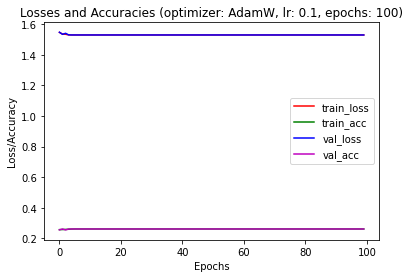

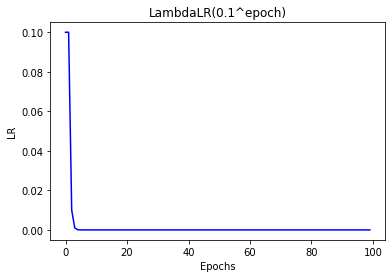

In [22]:

print(f"Optimizer: {op_name}")
optimizer = optimizers[op_name]
train_losses, train_accs, val_losses, val_accs, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

epochs = range(num_epochs)

plt.figure(1)
plt.plot(epochs, train_losses, 'r', label='train_loss')
plt.plot(epochs, train_accs, 'g', label='train_acc')
plt.plot(epochs, val_losses, 'b', label='val_loss')
plt.plot(epochs, val_accs, 'm', label='val_acc')

plt.title(f'Losses and Accuracies (optimizer: {op_name}, lr: {learning_rate}, epochs: {num_epochs})')

plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')

plt.legend()
plt.savefig(f"./results/Losses and Accuracies({op_name}).jpg", dpi=200)
plt.show()

plt.figure(2)
plt.plot(epochs, lrs, 'b')
plt.title(f'LambdaLR({lambda_c}^epoch)')

plt.xlabel('Epochs')
plt.ylabel('LR')
plt.savefig(f"./results/LambdaLR(optimizer: {op_name}, {lambda_c}^epoch).jpg", dpi=200)
